In [43]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import warnings
from datetime import datetime as dt
from darts import TimeSeries
from darts.models import(
        ExponentialSmoothing,
        ARIMA,
        Prophet,
        Theta
        )
from darts.metrics import mae, mase, rmse
from darts.utils.statistics import check_seasonality, plot_acf


In [6]:
# Shoot a warning that is generated by the Theta model for too high values of theta whilst finetuning
warnings.filterwarnings('ignore', message='Optimization failed to converge. Check mle_retvals.')

In [7]:
# Pre-processing of the data: loading, transforming the Date column values into pd.timestamp and cleaning column names
# changing it to an object that is actually recognised as a timestamp by Pandas
data = pd.read_csv('data.csv', index_col=False, names=['Date', 'Demand'] , header=0, thousands=',')
data['Date'] = pd.Series(pd.date_range("2007-10-01", freq='3M', periods=45))
#this is what the df object looks like
data

,Date,Demand
0,2007-10-31,1.12
1,2008-01-31,2.32
2,2008-04-30,1.70
3,2008-07-31,0.72
4,2008-10-31,6.89
5,2009-01-31,4.36
6,2009-04-30,3.79
7,2009-07-31,5.21
8,2009-10-31,7.37
9,2010-01-31,8.74


In [8]:
# Transform our dataframe into a TimeSeries object that we'll be using going forward
data_ts = TimeSeries.from_dataframe(data, time_col='Date')

In [9]:
# Is there seasonality in our dataset ?
seasonal_periods = []
for m in range (2, 25):
    is_seasonal, period = check_seasonality(data_ts, m=m, alpha=.05)
    if is_seasonal:
        seasonal_periods.append(period) 

In [10]:
print(f'The dataset seems to be seasonal on the following occurences :')

The dataset seems to be seasonal on the following occurences :


In [11]:
print(seasonal_periods)

[4, 8, 11]


In [12]:
# We want to check different models as we have little information on the nature of the business, constraints etc. Let's separate our timeseries object into a train and a validation set
train, validation = data_ts.split_before(pd.Timestamp('20160331'))

In [13]:
# We prepare objects that will be used to compare the results of the different models
model_forecast_matrix = pd.DataFrame(index=validation._time_index)
model_forecast_matrix['validation'] = validation.values()

model_forecast_matrix

,validation
Date,
2016-01-31,74.78
2016-04-30,51.19
2016-07-31,40.40
2016-10-31,45.51
2017-01-31,78.29
2017-04-30,50.76
2017-07-31,41.03
2017-10-31,46.68
2018-01-31,77.32


In [16]:
model_comparison_matrix = pd.DataFrame(index=['error_mae', 'error_mase', 'error_rmse'])

In [19]:
# We are going to use the same Modelise object to generate the answers for all of the different models, its cleaner to proceed this way
class Modelise():
    def __init__(self, model, train, validation,  **kwargs):
        self.model = model
        self.train = train
        self.validation = validation
        self.__dict__.update(kwargs)

        self.model.fit(self.train)

        return None
    def predict(self):
        forecast = self.model.predict(len(self.validation))

        return forecast

    def performance(self):
        error_mae = mae(self.validation, forecast)
        error_mase = mase(self.validation, forecast, self.train)
        error_rmse = rmse(self.validation, forecast)

        return error_mae, error_mase, error_rmse

In [20]:
# Perform on the Exponential smoothing model

model_exp = Modelise(ExponentialSmoothing(seasonal_periods=4), train, validation)

In [22]:
forecast = model_exp.predict()
forecast

<TimeSeries (DataArray) (time: 12, component: 1, sample: 1)>
array([[[82.19022831]],

       [[67.213958  ]],

       [[53.90264527]],

       [[59.0430244 ]],

       [[89.78831441]],

       [[74.8120441 ]],

       [[61.50073136]],

       [[66.64111049]],

       [[97.3864005 ]],

       [[82.41013019]],

       [[69.09881746]],

       [[74.23919659]]])
Coordinates:
  * time       (time) datetime64[ns] 2016-01-31 2016-04-30 ... 2018-10-31
  * component  (component) object 'Demand'
Dimensions without coordinates: sample

In [23]:
error_mae, error_mase, error_rmse = model_exp.performance()

In [27]:
model_comparison_matrix['exp_smooth'] = (error_mae, error_mase, error_rmse)
model_comparison_matrix

,exp_smooth
error_mae,19.321383
error_mase,3.027392
error_rmse,20.494326


In [26]:
model_forecast_matrix['exp_smooth'] = forecast.values()
model_forecast_matrix

,validation,exp_smooth
Date,,
2016-01-31,74.78,82.190228
2016-04-30,51.19,67.213958
2016-07-31,40.40,53.902645
2016-10-31,45.51,59.043024
2017-01-31,78.29,89.788314
2017-04-30,50.76,74.812044
2017-07-31,41.03,61.500731
2017-10-31,46.68,66.641110
2018-01-31,77.32,97.386401


In [28]:
# Perform on the ARIMA model:

model_arima = Modelise(ARIMA(), train, validation)
forecast = model_arima.predict()
error_mae, error_mase, error_rmse = model_arima.performance()

/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [29]:
model_comparison_matrix['arima'] = (error_mae, error_mase, error_rmse)
model_forecast_matrix['arima'] = forecast.values()

In [30]:
# Perform on the Facebook Prophet model (with finetuning)
    # Fine tune the best model

In [32]:
optimal_order = 0
best_error_rmse = float('inf')
finetune_prophet = dict()


In [33]:
for fourier_order in range(3, 20):
    temp_model = Modelise(Prophet(add_seasonalities={'name': 'trimestrial', 'seasonal_periods': 4, 'fourier_order': fourier_order}),
            train,
            validation
            )
    forecast = temp_model.predict()
    error_mae, error_mase, error_rmse = temp_model.performance()
    finetune_prophet[fourier_order] = (error_mae, error_mase, error_rmse) 
    if error_rmse < best_error_rmse:
        best_error_rmse = error_rmse
        optimal_order = fourier_order

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

In [34]:
 # Now that we have the optimal Fourier order lets perform the model and save the results

model_prophet = Modelise(Prophet(add_seasonalities={'name': 'trimestrial', 'seasonal_periods': 4, 'fourier_order': optimal_order}), train, validation)
forecast = model_prophet.predict()
error_mae, error_mase, error_rmse = model_prophet.performance()

model_comparison_matrix['prophet'] = (error_mae, error_mase, error_rmse)
model_forecast_matrix['prophet'] = forecast.values()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
# Perform on the Theta Method model (with finetuning)
    # Fine tune the best model
    
optimal_theta = 0
best_error_rmse = float('inf')
finetune_theta = dict()

In [38]:
for theta_ in np.linspace(-10, 10, 200):
    temp_model = Modelise(Theta(theta_, seasonality_period=4),
            train,
            validation)
    forecast = temp_model.predict()
    error_mae, error_mase, error_rmse = temp_model.performance()
    finetune_theta[theta_] = (error_mae, error_mase, error_rmse) 
    if error_rmse < best_error_rmse:
        best_error_rmse = error_rmse
        optimal_theta = theta_

In [39]:
# Now that we have the optimal theta lets perform the model and save the results

model_theta = Modelise(Theta(optimal_theta, seasonality_period=4), train, validation)
forecast = model_theta.predict()
error_mae, error_mase, error_rmse = model_theta.performance()

model_comparison_matrix['theta'] = (error_mae, error_mase, error_rmse)
model_forecast_matrix['theta'] = forecast.values()

<AxesSubplot:xlabel='Date'>

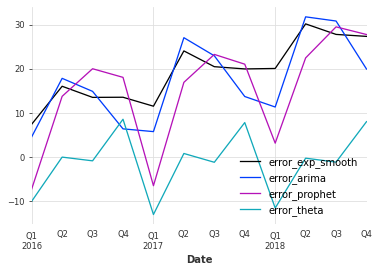

In [52]:
# Create error columns for each model to check the magnitude of errors given by each model
for item_ in ('exp_smooth', 'arima', 'prophet', 'theta'):
    model_forecast_matrix[f'error_{item_}'] = model_forecast_matrix[item_] - model_forecast_matrix['validation']
model_forecast_matrix.iloc[:,-4:].plot()


In [41]:
# Save the matrix in csv files
model_comparison_matrix.to_csv('model_comparison_matrix.csv')
model_forecast_matrix.to_csv('model_forecast_matrix.csv')

In [130]:
# Answer block so that you can see my thought process of handling the results whilst executing the script
print('\nThe comparison matrix of models is here : \n')
print(model_comparison_matrix)
print('\nThe Theta model beats the other models by a landslide, we shall select this one going forward to forecast the Iphone Sales from Q1 2019 to Q4 2021')
print('\nThe forecast for the validation timeseries given by each model is here : \n')
print(model_forecast_matrix)


The comparison matrix of models is here : 

            exp_smooth      arima    prophet     theta
error_mae    19.321383  17.241576  17.474753  5.297028
error_mase    3.027392   2.701515   2.738051  0.829971
error_rmse   20.494326  19.505216  19.228558  7.128974

The Theta model beats the other models by a landslide, we shall select this one going forward to forecast the Iphone Sales from Q1 2019 to Q4 2021

The forecast for the validation timeseries given by each model is here : 

            validation  exp_smooth      arima    prophet      theta  \
Date                                                                  
2016-01-31       74.78   82.190228  79.330742  67.492666  64.699076   
2016-04-30       51.19   67.213958  69.014184  64.931243  51.131414   
2016-07-31       40.40   53.902645  55.268556  60.405035  39.495565   
2016-10-31       45.51   59.043024  51.863508  63.557570  54.048839   
2017-01-31       78.29   89.788314  84.020952  71.739114  65.197850   
2017-04-30    

In [53]:
print('Now let\'s train the model with the full dataset and forecast accordingly.')

Now let's train the model with the full dataset and forecast accordingly.


In [54]:
# Now let's generate our answer now that we have selected our model and its parameters
# Here place the dataframe object of the real answer

dti = pd.date_range('2019-03-31', periods=12, freq='3M')
result_data = pd.DataFrame({"Date": dti, "Demand": (1,1,1,1,1,1,1,1,1,1,1,1)})

result_ts = TimeSeries.from_dataframe(result_data, time_col='Date')

In [55]:
# We prepare the objects to store our results
result_forecast_matrix = pd.DataFrame(index=result_ts._time_index)
result_forecast_matrix['real_data'] = result_ts.values()

In [56]:
result_comparison_matrix = pd.DataFrame(index=['error_mae', 'error_mase', 'error_rmse'])

In [57]:
# Perform on the Theta Method model (with finetuning)
    # Fine tune the best model
    
final_optimal_theta = 0
best_error_rmse = float('inf')
finetune_theta = dict()

for theta_ in np.linspace(-10, 10, 200):
    temp_model = Modelise(Theta(theta_, seasonality_period=4),
            train,
            validation)
    forecast = temp_model.predict()
    error_mae, error_mase, error_rmse = temp_model.performance()
    finetune_theta[theta_] = (error_mae, error_mase, error_rmse) 
    if error_rmse < best_error_rmse:
        best_error_rmse = error_rmse
        final_optimal_theta = theta_

print(f'\nThe optimal theta found is {final_optimal_theta}')

if final_optimal_theta == optimal_theta:
    print(f'We found the same optimal theta ({optimal_theta}), at least we know it is a bit more solid.')
else:
    print(f'We found the new optimal theta which is : {final_optimal_theta}')


The optimal theta found is 1.0552763819095485
We found the same optimal theta (1.0552763819095485), at least we know it is a bit more solid.


In [136]:
# Now that we have the optimal theta lets perform the model and save the results

model_theta = Modelise(Theta(final_optimal_theta, seasonality_period=4), data_ts, result_ts)
forecast = model_theta.predict()
result_forecast_matrix['theta'] = forecast.values()

# Final output
print('\nThe forecast given by our Theta model for the time period starting at Q1 2019 until Q4 2021 is here: \n')
print(result_forecast_matrix)


The forecast given by our Theta model for the time period starting at Q1 2019 until Q4 2021 is here: 

            real_data      theta
Date                            
2019-03-31        1.0  64.683028
2019-06-30        1.0  48.852199
2019-09-30        1.0  38.323988
2019-12-31        1.0  50.317897
2020-03-31        1.0  65.083448
2020-06-30        1.0  49.154152
2020-09-30        1.0  38.560500
2020-12-31        1.0  50.627951
2021-03-31        1.0  65.483869
2021-06-30        1.0  49.456104
2021-09-30        1.0  38.797013
2021-12-31        1.0  50.938005


In [ ]:
# Our prediction is 38.797